# Operational Load Hotspots

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 150          # display resolution
plt.rcParams["savefig.dpi"] = 300         # saved image quality

## Load Datasets

In [3]:
ENROL1_PATH = 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_0_500000.csv'
ENROL2_PATH = 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_500000_1000000.csv'
ENROL3_PATH = 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_1000000_1006029.csv'

DEMO1_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_0_500000.csv'
DEMO2_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_500000_1000000.csv'
DEMO3_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_1000000_1500000.csv'
DEMO4_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_1500000_2000000.csv'
DEMO5_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_2000000_2071700.csv'

BIO1_PATH = 'api_data_aadhar_biometric/api_data_aadhar_biometric_0_500000.csv'
BIO2_PATH = 'api_data_aadhar_biometric/api_data_aadhar_biometric_500000_1000000.csv'
BIO3_PATH = 'api_data_aadhar_biometric/api_data_aadhar_biometric_1000000_1500000.csv'
BIO4_PATH = 'api_data_aadhar_biometric/api_data_aadhar_biometric_1500000_1861108.csv'

In [4]:
enrol1= pd.read_csv(ENROL1_PATH)
enrol2= pd.read_csv(ENROL2_PATH)
enrol3= pd.read_csv(ENROL3_PATH)

demo1= pd.read_csv(DEMO1_PATH)
demo2= pd.read_csv(DEMO2_PATH)
demo3= pd.read_csv(DEMO3_PATH)
demo4= pd.read_csv(DEMO4_PATH)
demo5= pd.read_csv(DEMO5_PATH)

bio1= pd.read_csv(BIO1_PATH)
bio2= pd.read_csv(BIO2_PATH)
bio3= pd.read_csv(BIO3_PATH)
bio4= pd.read_csv(BIO4_PATH)

## Minimal Cleaning & Alignment

In [5]:
enrol= pd.concat([enrol1, enrol2, enrol3], ignore_index= True)

In [6]:
demo= pd.concat([demo1, demo2, demo3, demo4, demo5], ignore_index= True)
bio= pd.concat([bio1, bio2, bio3, bio4], ignore_index= True)

In [7]:
enrol.drop(columns= ['date'], inplace= True)

In [8]:
demo.drop(columns= ['date'], inplace= True)
bio.drop(columns= ['date'], inplace= True)

## Feature Engineering

In [9]:
enrol["total_enrolments"] = (
    enrol["age_0_5"] +
    enrol["age_5_17"] +
    enrol["age_18_greater"]
)

In [10]:
demo["demo_activity"] = (
    demo["demo_age_5_17"] +
    demo["demo_age_17_"]
)
bio["bio_activity"] = (
    bio["bio_age_5_17"] +
    bio["bio_age_17_"]
)

In [11]:
# enrol.to_csv('enrol_clean.csv')
# demo.to_csv('demo_clean.csv')
# bio.to_csv('bio_clean.csv')

## Aggregate at District Level

In [12]:
enrol_dist = (
    enrol.groupby(["state", "district"], as_index=False)
         ["total_enrolments"]
         .sum()
)

demo_dist = (
    demo.groupby(["state", "district"], as_index=False)
        ["demo_activity"]
        .sum()
)

bio_dist = (
    bio.groupby(["state", "district"], as_index=False)
       ["bio_activity"]
       .sum()
)

## Merge Datasets

In [13]:
district_df = (
    enrol_dist
    .merge(demo_dist, on=["state", "district"], how="left")
    .merge(bio_dist, on=["state", "district"], how="left")
)

district_df.fillna(0, inplace=True)

In [14]:
district_df.head()

,state,district,total_enrolments,demo_activity,bio_activity
0,100000,100000,218,2.0,0.0
1,Andaman & Nicobar Islands,Andamans,75,750.0,2015.0
2,Andaman & Nicobar Islands,Nicobars,1,4.0,2.0
3,Andaman & Nicobar Islands,South Andaman,38,305.0,367.0
4,Andaman and Nicobar Islands,Nicobar,75,787.0,1811.0


## Compute Operational Load

In [15]:
district_df["total_activity"] = (
    district_df["total_enrolments"] +
    district_df["demo_activity"] +
    district_df["bio_activity"]
)
district_df["activity_per_enrolment"] = (
    district_df["total_activity"] /
    district_df["total_enrolments"].replace(0, np.nan)
)

## Identify Hotspots

In [16]:
threshold = district_df["total_activity"].quantile(0.90)

hotspots = district_df[
    district_df["total_activity"] >= threshold
].sort_values("total_activity", ascending=False)

In [17]:
hotspots.head()

,state,district,total_enrolments,demo_activity,bio_activity,total_activity,activity_per_enrolment
563,Maharashtra,Pune,31763,438478.0,605762.0,1076003.0,33.875988
572,Maharashtra,Thane,43688,447253.0,571273.0,1062214.0,24.313633
559,Maharashtra,Nashik,22368,246100.0,576606.0,845074.0,37.780490
234,Gujarat,Ahmedabad,19130,267884.0,405490.0,692504.0,36.199895
266,Gujarat,Surat,25469,357582.0,281599.0,664650.0,26.096431


## Visualization: Top Load Districts

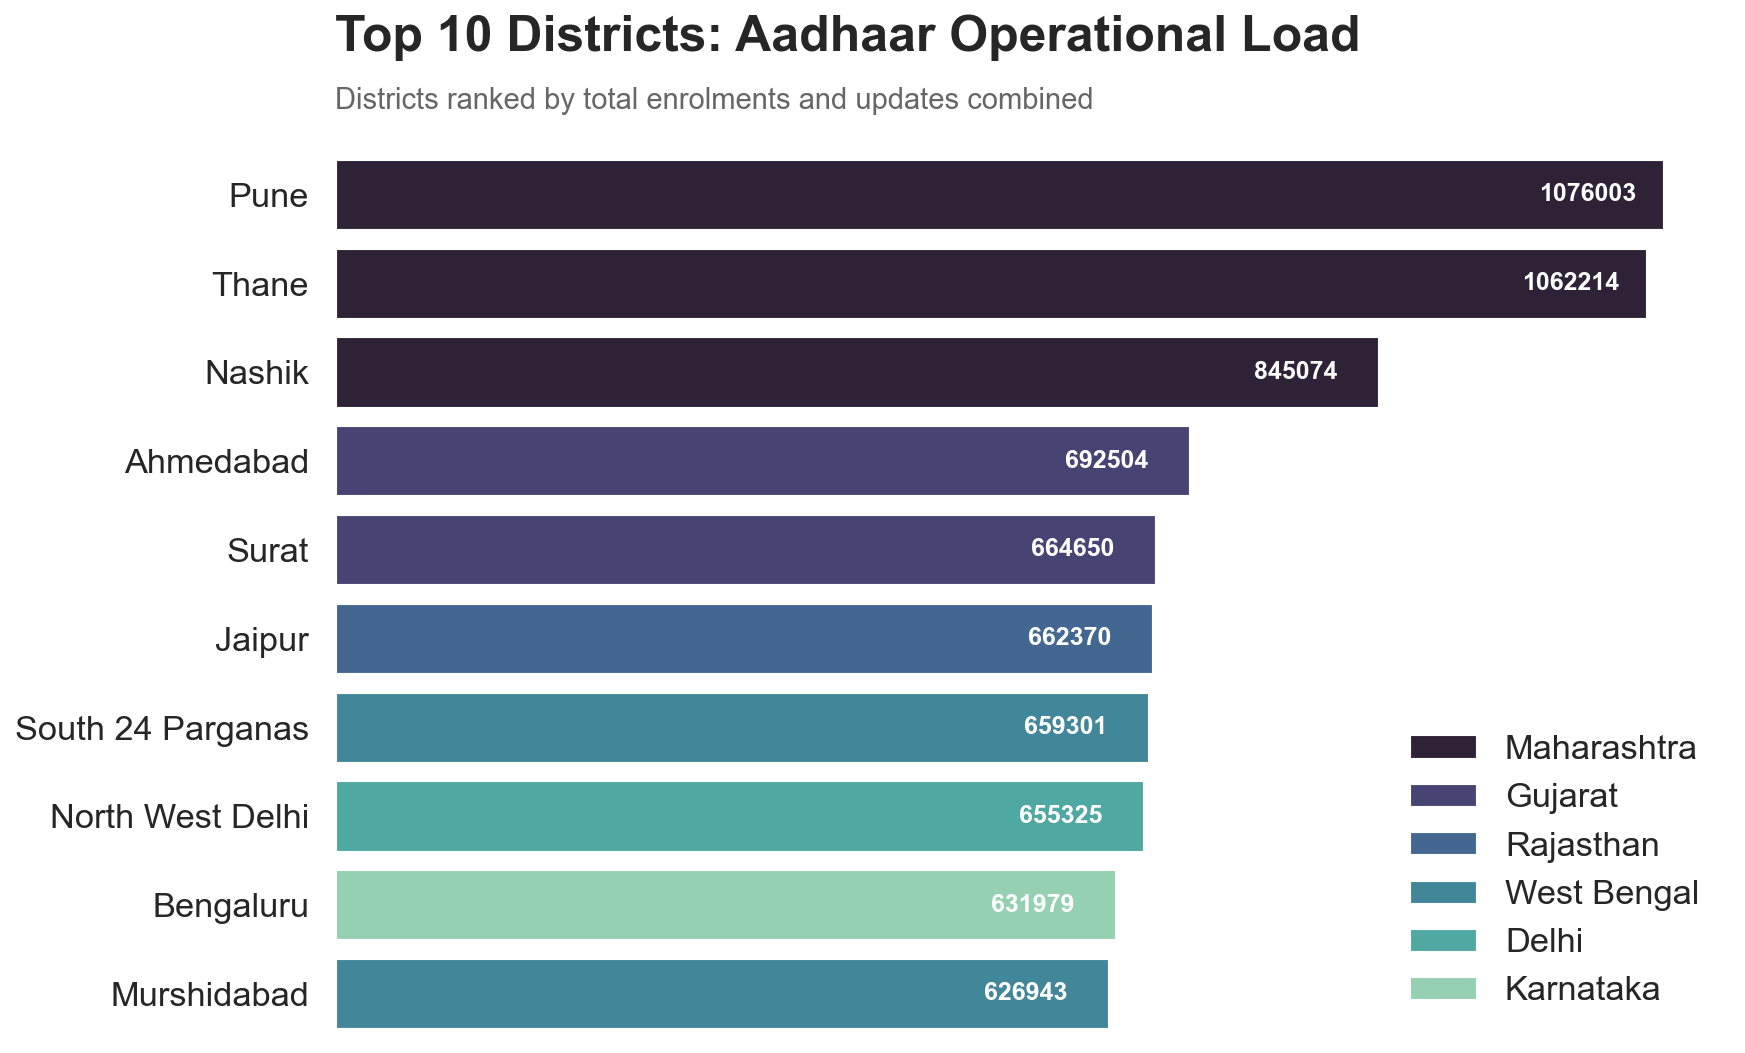

In [18]:
top10 = hotspots.head(10)

sns.set_context("talk")
sns.set_style("white") # Remove grid for a cleaner look

# plot
ax = sns.barplot(
    data=top10,
    y="district",
    x="total_activity",
    hue="state",
    palette="mako", # 'mako' is a very sleek teal/blue palette
    dodge=False
)

plt.text(x=0, y=1.1, s="Top 10 Districts: Aadhaar Operational Load", 
         fontsize=24, weight='bold', ha='left', va='bottom', transform=ax.transAxes)

plt.text(x=0, y=1.04, s="Districts ranked by total enrolments and updates combined", 
         fontsize=14, color='#666666', ha='left', va='bottom', transform=ax.transAxes)

# --- Data Labels ---
# Added color='white' for better contrast against the dark bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=-60, fontsize=12, color='white', weight='bold')

# Cleanup
plt.xlabel("")
plt.ylabel("") 
plt.xticks([]) # Remove x-axis numbers
sns.despine(left=True, bottom=True) # Remove border

# Legend
plt.legend(loc="lower right", frameon=False)
plt.subplots_adjust(top=0.85)

plt.show()

## Insight: Operational Load Hotspots

### Certain districts exhibit disproportionately high Aadhaar activity when enrolment, demographic activity, and biometric activity are combined.

These hotspots represent regions where:
- Service demand is consistently high
- Infrastructure and staffing pressure is likely concentrated
- Proactive resource planning can reduce citizen friction

This insight is derived purely from aggregated activity patterns and does not rely
on individual-level behavior or assumptions.

# Pincode-Level Drill-Down

In [19]:
top10_districts = (
    district_df
    .sort_values("total_activity", ascending=False)
    .head(10)[["state", "district"]]
)

top10_districts

,state,district
563,Maharashtra,Pune
572,Maharashtra,Thane
559,Maharashtra,Nashik
234,Gujarat,Ahmedabad
266,Gujarat,Surat
771,Rajasthan,Jaipur
1057,West Bengal,South 24 Parganas
224,Delhi,North West Delhi
397,Karnataka,Bengaluru
1044,West Bengal,Murshidabad


In [21]:
def filter_top_districts(df, top_districts):
    return df.merge(
        top_districts,
        on=["state", "district"],
        how="inner"
    )

enrol_top = filter_top_districts(enrol, top10_districts)
demo_top  = filter_top_districts(demo, top10_districts)
bio_top   = filter_top_districts(bio, top10_districts)

## Recompute Activity at Pincode Level

In [23]:
enrol_top["total_enrolments"] = (
    enrol_top["age_0_5"] +
    enrol_top["age_5_17"] +
    enrol_top["age_18_greater"]
)

demo_top["demo_activity"] = (
    demo_top["demo_age_5_17"] +
    demo_top["demo_age_17_"]
)

bio_top["bio_activity"] = (
    bio_top["bio_age_5_17"] +
    bio_top["bio_age_17_"]
)

In [24]:
enrol_pin = (
    enrol_top.groupby(["state", "district", "pincode"], as_index=False)
             ["total_enrolments"].sum()
)

demo_pin = (
    demo_top.groupby(["state", "district", "pincode"], as_index=False)
            ["demo_activity"].sum()
)

bio_pin = (
    bio_top.groupby(["state", "district", "pincode"], as_index=False)
           ["bio_activity"].sum()
)

In [25]:
pincode_df = (
    enrol_pin
    .merge(demo_pin, on=["state", "district", "pincode"], how="left")
    .merge(bio_pin, on=["state", "district", "pincode"], how="left")
)

pincode_df.fillna(0, inplace=True)

pincode_df["total_activity"] = (
    pincode_df["total_enrolments"] +
    pincode_df["demo_activity"] +
    pincode_df["bio_activity"]
)

pincode_df.head()

,state,district,pincode,total_enrolments,demo_activity,bio_activity,total_activity
0,Delhi,North West Delhi,110009,391,6953.0,7651.0,14995.0
1,Delhi,North West Delhi,110033,1018,42248.0,28100.0,71366.0
2,Delhi,North West Delhi,110034,2318,30665.0,14512.0,47495.0
3,Delhi,North West Delhi,110035,316,8003.0,7740.0,16059.0
4,Delhi,North West Delhi,110036,483,8362.0,11753.0,20598.0


## Compute Pincode Share Within District

In [26]:
pincode_df["district_total_activity"] = (
    pincode_df.groupby(["state", "district"])["total_activity"]
              .transform("sum")
)

pincode_df["pincode_activity_share"] = (
    pincode_df["total_activity"] /
    pincode_df["district_total_activity"]
)

## Identify Pincode “Gravity Points”

In [ ]:
gravity_pincodes = pincode_df[
    pincode_df["pincode_activity_share"] >= 0.10
].sort_values(
    ["state", "district", "pincode_activity_share"],
    ascending=False
)

gravity_pincodes

,state,district,pincode,total_enrolments,demo_activity,bio_activity,total_activity,district_total_activity,pincode_activity_share
641,Rajasthan,Jaipur,302012,3629,49777.0,25231.0,78637.0,662354.0,0.118724
613,Maharashtra,Thane,421302,7796,61366.0,49979.0,119141.0,1062085.0,0.112177
378,Maharashtra,Nashik,423203,6058,22080.0,58470.0,86608.0,845039.0,0.102490
185,Gujarat,Surat,395010,3847,53316.0,30806.0,87969.0,664627.0,0.132358
121,Gujarat,Surat,394210,4306,45269.0,33656.0,83231.0,664627.0,0.125230
181,Gujarat,Surat,395006,3327,45488.0,21474.0,70289.0,664627.0,0.105757
14,Delhi,North West Delhi,110086,2899,55605.0,66190.0,124694.0,655325.0,0.190278
7,Delhi,North West Delhi,110042,1387,32362.0,46785.0,80534.0,655325.0,0.122892
13,Delhi,North West Delhi,110085,2707,46275.0,27746.0,76728.0,655325.0,0.117084
1,Delhi,North West Delhi,110033,1018,42248.0,28100.0,71366.0,655325.0,0.108902


## Visualization: Pincode Concentration

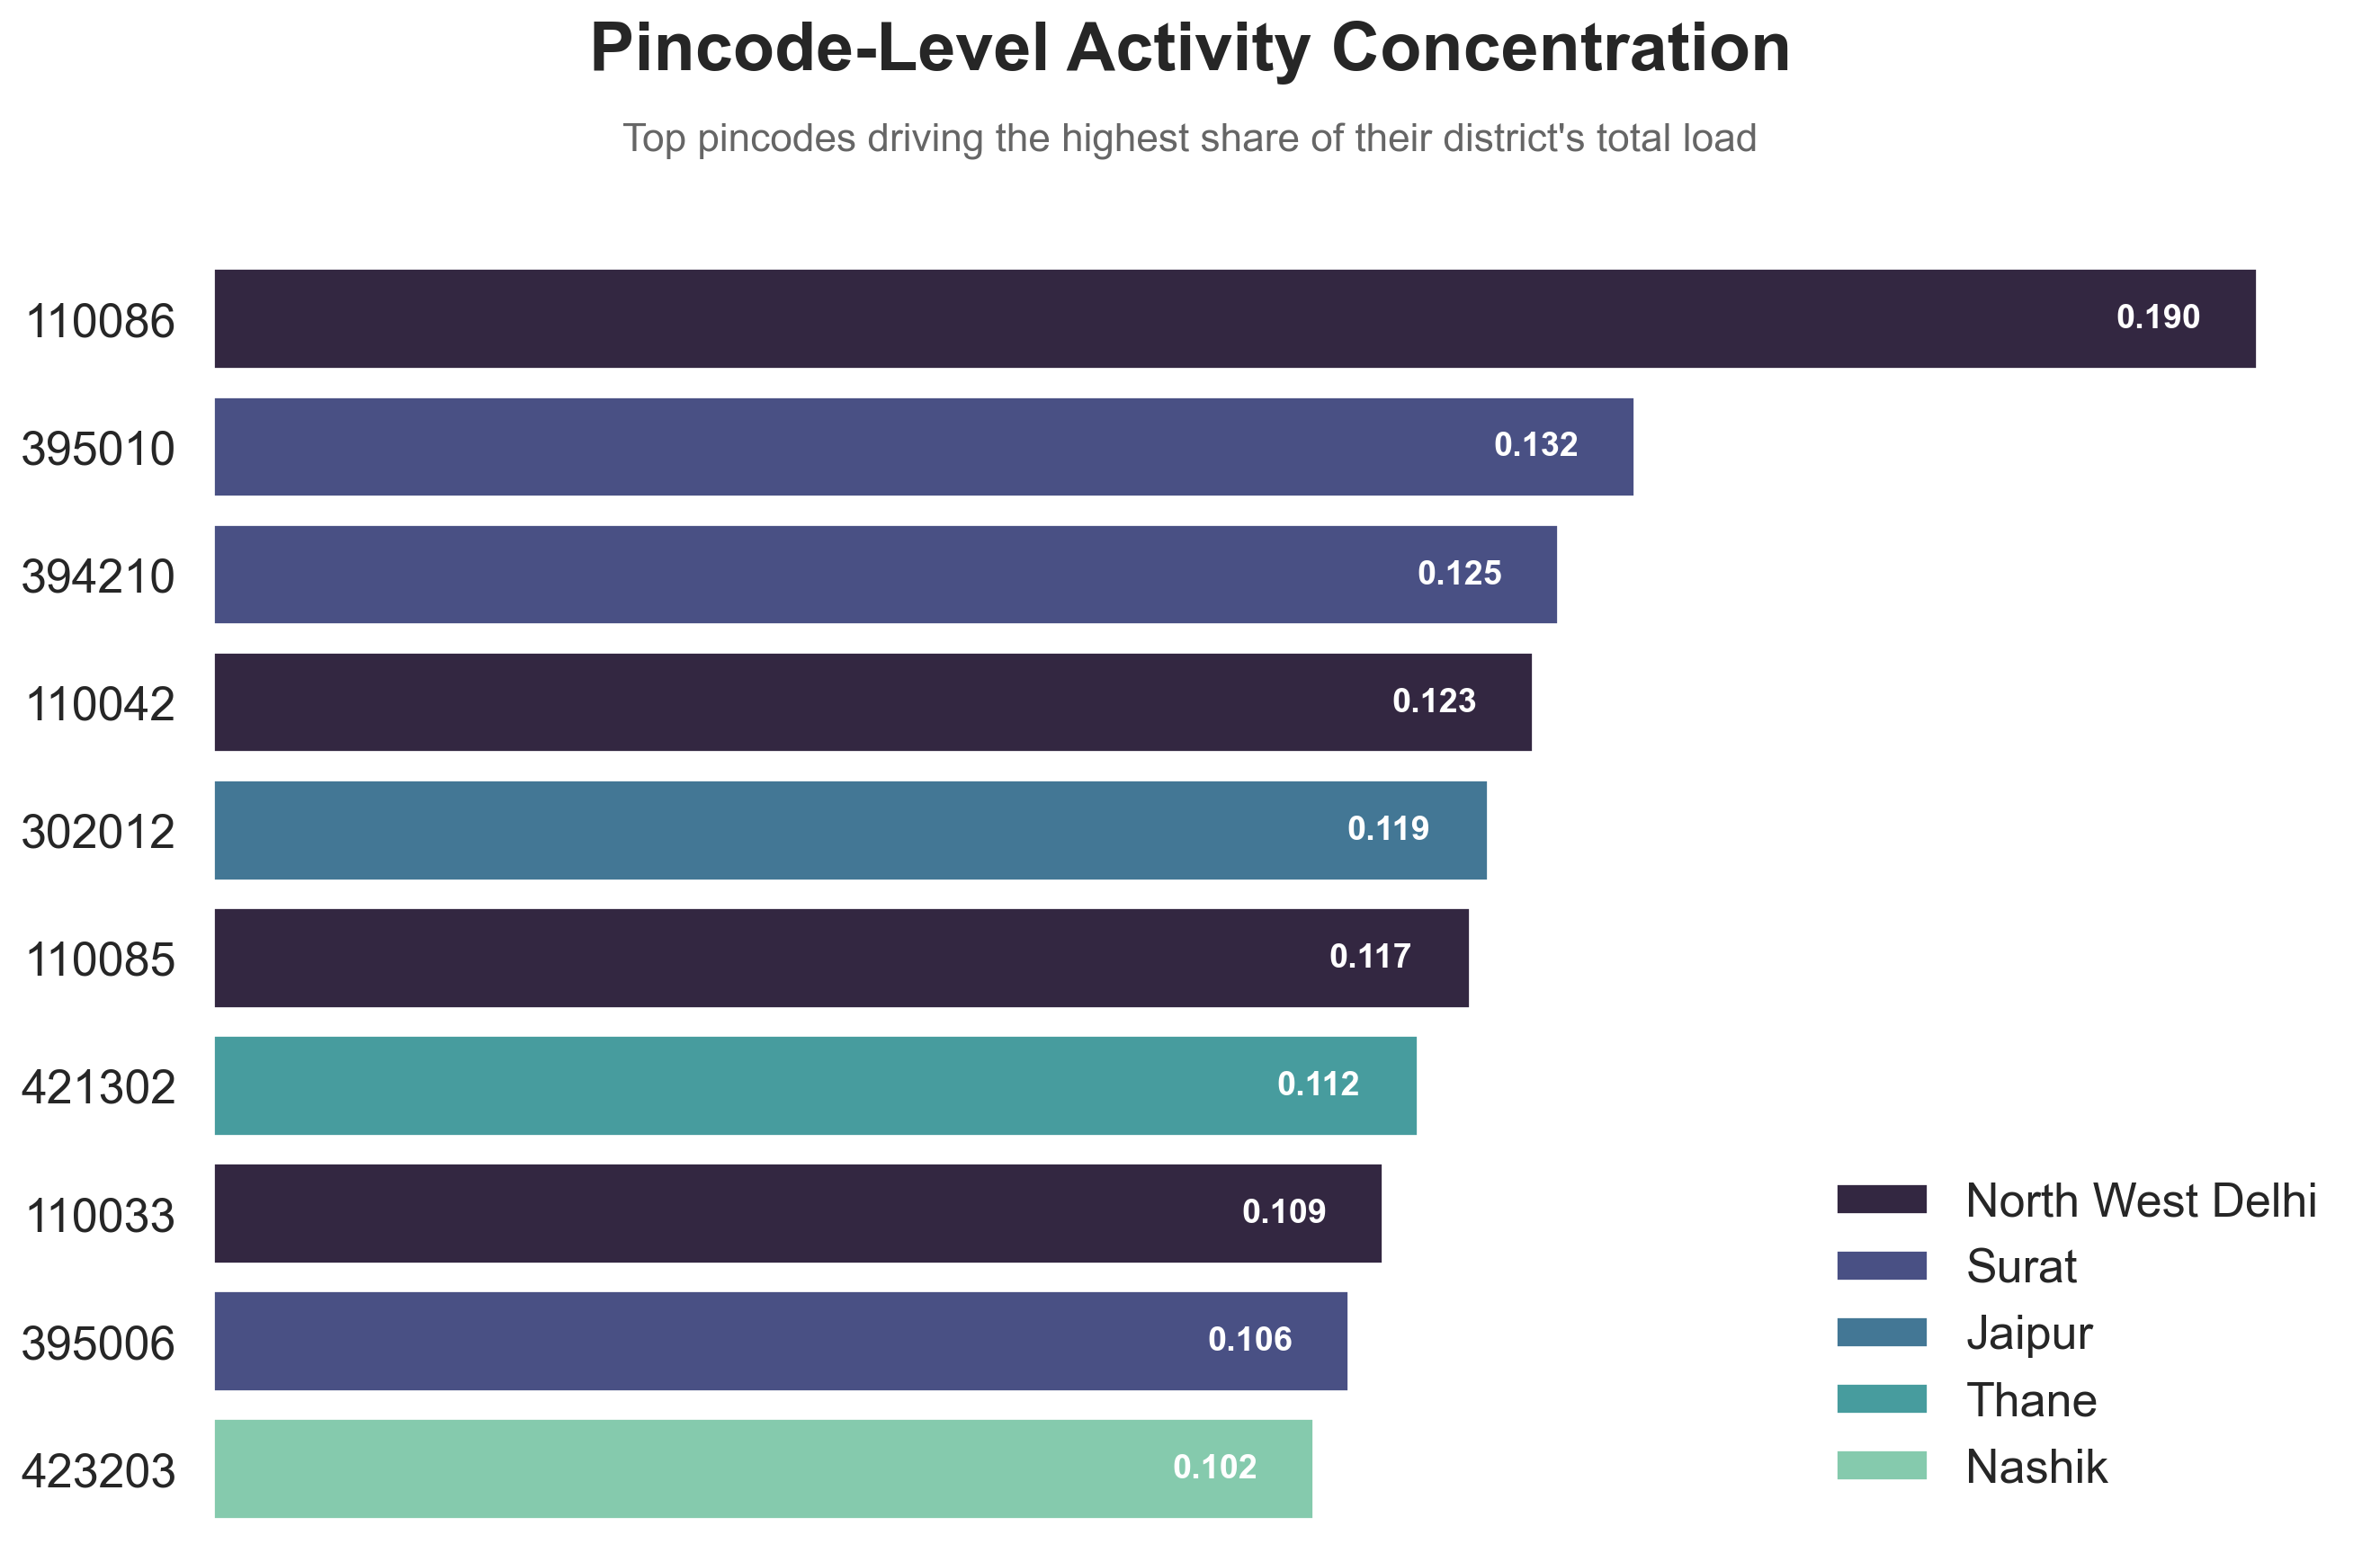

In [ ]:
sns.set_context("talk")
sns.set_style("white")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 227

# 1. PREPARE & SORT THE DATA
top_pins_clean = gravity_pincodes.head(10).copy()
top_pins_clean = top_pins_clean.sort_values("pincode_activity_share", ascending=False)

if 'pincode' in top_pins_clean.columns:
    top_pins_clean['pincode'] = top_pins_clean['pincode'].astype(str)

# 2. PLOT
ax = sns.barplot(
    data=top_pins_clean,
    y="pincode",
    x="pincode_activity_share",
    hue="district",
    palette="mako",
    dodge=False
)

# 3. TITLES (Center Aligned)
plt.figtext(0.5, 0.93, "Pincode-Level Activity Concentration", 
            fontsize=24, weight='bold', ha='center')

plt.figtext(0.5, 0.88, "Top pincodes driving the highest share of their district's total load", 
            fontsize=14, color='#666666', ha='center')

# 4. DATA LABELS
for container in ax.containers:
    # fmt='%.2f' is good, but %.0% (e.g., 19%) might be faster to read for judges
    ax.bar_label(container, fmt='%.3f', padding=-50, fontsize=12, color='white', weight='bold')

# 5. CLEANUP
plt.xlabel("")
plt.ylabel("")
plt.xticks([]) 
sns.despine(left=True, bottom=True)

# 6. LEGEND (Lower Right)
sns.move_legend(
    ax, "lower right",
    bbox_to_anchor=(1, 0),
    title="",
    frameon=False,
)

# 7. LAYOUT
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()

## Insight: Pincode-Level Concentration Effects

### Within high-load districts, Aadhaar activity is not evenly distributed across pincodes. A small number of pincodes account for a disproportionate share of total activity.

These pincodes act as local “gravity points” where:
- Service demand is highly concentrated
- Infrastructure stress is localized
- Small capacity upgrades can have outsized impact

This insight enables targeted, pincode-level operational planning
within already identified high-load districts.